## Combining All ML Models to Compare in ROC Graph

In [2]:
# Load dependencies for all models
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

from keras.models import Sequential
from sklearn.preprocessing import StandardScaler
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense

import matplotlib
%matplotlib inline  
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import recall_score
from sklearn.metrics import classification_report
import pickle

from sklearn.metrics import confusion_matrix
import itertools

from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

Using TensorFlow backend.


In [4]:
df = pd.read_csv("../data/Data_USD.csv")
df.head()

,LIMIT_BAL_US,SEX,EDUCATION,MARRIAGE,AGE,PAY_SCORE_AVG,BILL_AVG_US,PAY_AMT_AVG_US,PAY_TO_BILL,CREDIT_UTILIZATION,DEFAULT_PAYMENT_NEXT_MO
0,725.714286,2,2,1,24,-0.33,46.590857,4.166810,0.09,0.195650,1
1,4354.285714,2,2,2,26,0.50,103.275191,30.238095,0.29,0.022350,1
2,3265.714286,2,2,2,34,0.00,614.758619,66.632667,0.11,0.324878,0
3,1814.285714,2,2,1,37,0.00,1399.019905,50.727429,0.04,0.939800,0
4,1814.285714,1,2,1,57,-0.33,661.240619,357.105857,0.54,0.172340,0


In [5]:
print("Original shape of the data: "+ str(df.shape))
features_names = df.columns

Original shape of the data: (30000, 11)


In [6]:
X = df.drop('DEFAULT_PAYMENT_NEXT_MO', axis =1).values
y = df['DEFAULT_PAYMENT_NEXT_MO'].values
print(X.shape)
print(y.shape)

(30000, 10)
(30000,)


Split my data into training and testing

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

## Instantiate the random forest model with 200 trees

In [8]:
rf = RandomForestClassifier(n_estimators=200)
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

Check feature importance

In [9]:
sorted(zip(rf.feature_importances_, features_names), reverse=True) 

[(0.19302880605773923, 'PAY_SCORE_AVG'),
 (0.14853329966970746, 'PAY_AMT_AVG_US'),
 (0.14465767805996266, 'CREDIT_UTILIZATION'),
 (0.14321025569654192, 'BILL_AVG_US'),
 (0.11575646809798867, 'AGE'),
 (0.094731314447065479, 'LIMIT_BAL_US'),
 (0.081481966527358771, 'PAY_TO_BILL'),
 (0.034670339953179419, 'EDUCATION'),
 (0.022777249248924145, 'MARRIAGE'),
 (0.021152622241532536, 'SEX')]

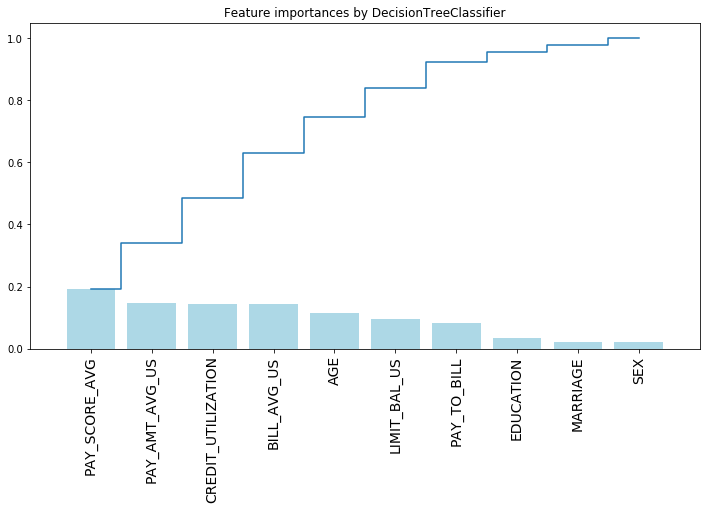

In [10]:
## plot the importances ##
import matplotlib.pyplot as plt
importances = rf.feature_importances_


indices = np.argsort(importances)[::-1]
plt.figure(figsize=(12,6))
plt.title("Feature importances by DecisionTreeClassifier")
plt.bar(range(len(indices)), importances[indices], color='lightblue',  align="center")
plt.step(range(len(indices)), np.cumsum(importances[indices]), where='mid', label='Cumulative')
plt.xticks(range(len(indices)), features_names[indices], rotation='vertical',fontsize=14)
plt.xlim([-1, len(indices)])
plt.show()

Making my prediction and seeing how well my model predicted by checking recall, precision, F1 score and making a confusion matrix.
Recall -tells us generally or overall how well our model predicted based on the total of how much it correctly predicted /correctly predicted + how many where actually right but predicted wrong.

                    formula = TP/TP+FN
Precision -tells us or gives us true measure how well our model predicted it shows correctly predicted /correctly predicted + how many the model predicted to be positive but where false.

                   formula = TP/TP+FP
F1 score - gives us a mean of precision and recall, a sumarization of how well it did in respect to recall and precision.

In [11]:
#Make my predictions
rf_y_prediction = rf.predict(X_test)

In [12]:
rf_roc_auc = roc_auc_score(y_test, rf.predict(X_test))

In [13]:
print(classification_report(y_test, rf_y_prediction,
                            target_names=["non_default", "default"]))

             precision    recall  f1-score   support

non_default       0.83      0.94      0.88      7742
    default       0.58      0.32      0.41      2158

avg / total       0.78      0.80      0.78      9900



In [14]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[7253  489]
 [1470  688]]
Normalized confusion matrix
[[ 0.94  0.06]
 [ 0.68  0.32]]


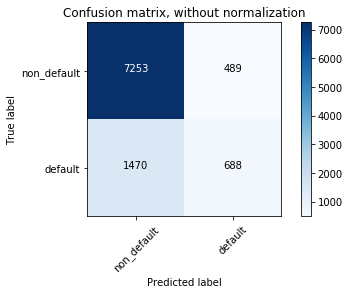

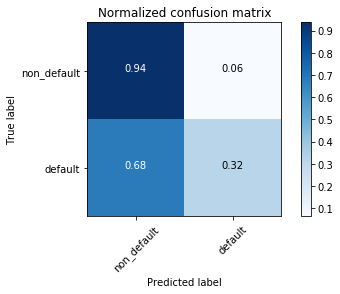

In [15]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, rf_y_prediction)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['non_default', 'default'],
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['non_default', 'default'], normalize=True,
                      title='Normalized confusion matrix')

plt.show()

Explanation of this confusion matrix
In our confusion matrix, the non-default classification has a total of 2,158 points and defualt clssification has a total of 7,742 points.

It correctly identified 7239 points as default and 503 points as non-default.

Non_default classification incorectly predicted 1480 points as default and correctly classified 678 points as Non defualt.

## Launch Neural Network Model

In [16]:
X_scaler = StandardScaler().fit(X_train)

In [17]:
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [18]:
y_train_categorical = to_categorical(y_train)
y_test_categorical = to_categorical(y_test)

In [19]:
nn_model = Sequential()

In [20]:
nn_model.add(Dense(units = 30, activation ='relu', input_dim=10))
nn_model.add(Dense(units = 20, activation ='relu')) #second hidden layer

In [21]:

nn_model.add(Dense(units = 2, activation = 'softmax'))

In [22]:
nn_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 30)                330       
_________________________________________________________________
dense_2 (Dense)              (None, 20)                620       
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 42        
Total params: 992
Trainable params: 992
Non-trainable params: 0
_________________________________________________________________


In [23]:
#compile the model
nn_model.compile(optimizer = 'adam' ,
             loss = 'categorical_crossentropy',
             metrics =['accuracy'])

In [24]:
#train the model

nn_model.fit(X_train_scaled, y_train_categorical, epochs=100,shuffle = True,verbose =2)

Epoch 1/100
 - 2s - loss: 0.4969 - acc: 0.7868
Epoch 2/100
 - 1s - loss: 0.4668 - acc: 0.8034
Epoch 3/100
 - 1s - loss: 0.4596 - acc: 0.8057
Epoch 4/100
 - 1s - loss: 0.4559 - acc: 0.8059
Epoch 5/100
 - 1s - loss: 0.4531 - acc: 0.8073
Epoch 6/100
 - 1s - loss: 0.4513 - acc: 0.8077
Epoch 7/100
 - 1s - loss: 0.4502 - acc: 0.8060
Epoch 8/100
 - 1s - loss: 0.4491 - acc: 0.8071
Epoch 9/100
 - 1s - loss: 0.4481 - acc: 0.8064
Epoch 10/100
 - 1s - loss: 0.4471 - acc: 0.8067
Epoch 11/100
 - 1s - loss: 0.4461 - acc: 0.8073
Epoch 12/100
 - 1s - loss: 0.4457 - acc: 0.8064
Epoch 13/100
 - 1s - loss: 0.4447 - acc: 0.8071
Epoch 14/100
 - 1s - loss: 0.4445 - acc: 0.8075
Epoch 15/100
 - 1s - loss: 0.4437 - acc: 0.8074
Epoch 16/100
 - 1s - loss: 0.4431 - acc: 0.8078
Epoch 17/100
 - 1s - loss: 0.4429 - acc: 0.8077
Epoch 18/100
 - 1s - loss: 0.4426 - acc: 0.8078
Epoch 19/100
 - 1s - loss: 0.4417 - acc: 0.8076
Epoch 20/100
 - 1s - loss: 0.4412 - acc: 0.8086
Epoch 21/100
 - 1s - loss: 0.4403 - acc: 0.8075
E

In [25]:
model_loss, model_accuracy = nn_model.evaluate(X_test_scaled,y_test_categorical,verbose =2)
print( model_loss )
print (model_accuracy)

0.454671125039
0.796161616138


In [26]:
nn_y_prediction = nn_model.predict_classes(X_test)

In [27]:
nn_roc_auc = roc_auc_score(y_test, nn_model.predict_classes(X_test))

In [28]:
print(classification_report(y_test, nn_y_prediction,
                            target_names=['non_default', 'default']))

             precision    recall  f1-score   support

non_default       0.82      0.64      0.72      7742
    default       0.28      0.50      0.36      2158

avg / total       0.70      0.61      0.64      9900



Confusion matrix, without normalization
[[4957 2785]
 [1084 1074]]
Normalized confusion matrix
[[ 0.64  0.36]
 [ 0.5   0.5 ]]


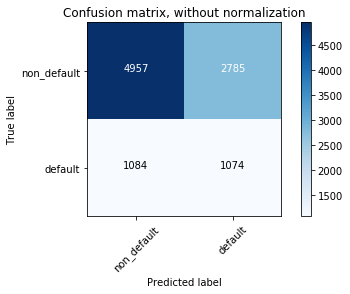

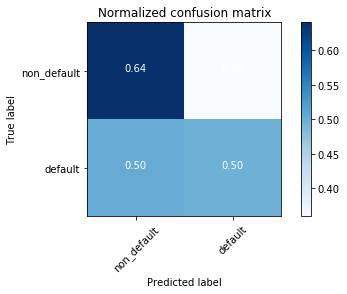

In [29]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, nn_y_prediction)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['non_default', 'default'],
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['non_default', 'default'], normalize=True,
                      title='Normalized confusion matrix')

plt.show()

## Logistic Regression Model 

In [30]:
#creating logistic regression model
classifier = LogisticRegression()
classifier

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [31]:
#fitting the model
classifier.fit(X_train, y_train) 

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [32]:
log_y_prediction = classifier.predict(X_test)

In [33]:
log_roc_auc = roc_auc_score(y_test, classifier.predict(X_test))

In [34]:
print(classification_report(y_test, log_y_prediction,
                            target_names=['non_default', 'default' ]))

             precision    recall  f1-score   support

non_default       0.80      0.99      0.88      7742
    default       0.67      0.09      0.16      2158

avg / total       0.77      0.79      0.72      9900



Confusion matrix, without normalization
[[7646   96]
 [1959  199]]
Normalized confusion matrix
[[ 0.99  0.01]
 [ 0.91  0.09]]


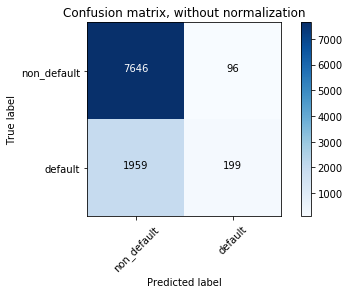

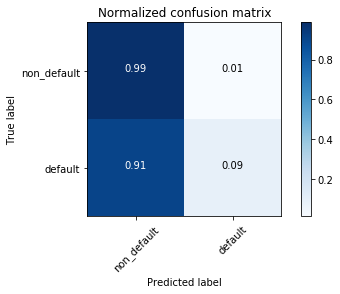

In [35]:
cnf_matrix = confusion_matrix(y_test, log_y_prediction)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['non_default', 'default'],
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['non_default', 'default'], normalize=True,
                      title='Normalized confusion matrix')

plt.show()

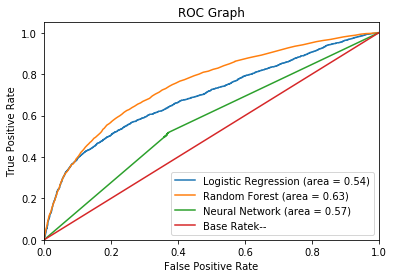

In [37]:
fpr, tpr, thresholds = roc_curve(y_test, classifier.predict_proba(X_test)[:,1])
rf_fpr, rf_tpr, rf_thresholds = roc_curve(y_test, rf.predict_proba(X_test)[:,1])
nn_fpr, nn_tpr, nn_thresholds = roc_curve(y_test, nn_model.predict_proba(X_test)[:,1])

plt.figure()

# Plot Logistic Regression ROC
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % log_roc_auc)

# Plot Random Forest ROC
plt.plot(rf_fpr, rf_tpr, label='Random Forest (area = %0.2f)' % rf_roc_auc)

# Plot Decision Tree ROC
plt.plot(nn_fpr, nn_tpr, label='Neural Network (area = %0.2f)' % nn_roc_auc)

# Plot Base Rate ROC
plt.plot([0,1], [0,1],label='Base Rate' 'k--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Graph')
plt.legend(loc="lower right")
plt.savefig('../static/images/ROC.png')
plt.show()